# **Cell Nuclei Detection via Semantic Image Segmentation with pre-trained modified U-Net**

## Methodology of the model training




1.   The dataset is retrieved from [here](https://www.kaggle.com/c/data-science-bowl-2018/)
2.   Data Loading and pre-analyse. The data has been initally set into train and test folder. 
3.   Data preprocessing - normalization of the input image and mask and convert the mask into numerical encoding
4.   Perform train_test_split of the train dataset to split the train data into train_dataset and validation_dataset. Test_dataset will be used in prediction of the trained model.
5.   Convert the data into tensor_slices and zip the tensor_slices. The data is then converted into prefetch dataset for better performance. Refer link [here](https://www.tensorflow.org/guide/data_performance)
6.   Prepare the U-net model - the model is modified from the pre-trained model MobileNetV2 has been used as the feature extraction("downward stack") and the decoder/"upward stack" is extracted from pix2pix. Pix2Pix is a Generative Adversarial Network, or GAN, model designed for general purpose image-to-image translation.
7.   Compile the model
8.   Create fucntions for image display and mask prediction
9.   Train the model - EarlyStopping callback is set to avoid overfitting
10.  Plot the Training Loss and Accuracy curve
11.  Deploy the model by doing predictions
12.  Save the model for future use 


In [1]:
# pip install tensorflow_examples for pix2pix loading
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-0izax2uh
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-0izax2uh


In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from scipy import io
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Unzip the file from google drive to "content-sample_data" folder
!unzip -uq "/content/drive/MyDrive/data-science-bowl-2018.zip" -d "/content/sample_data"

In [5]:
# Data Loading and Preparation
# Prepare a list for image and mask
train_file_directory = r"/content/sample_data/data-science-bowl-2018-2/train"
test_file_directory = r"/content/sample_data/data-science-bowl-2018-2/test"

In [6]:
# Load the input images
# define the function to load the train and test input image
def load_inputs(file_path_dir):
  inputs = []
  for inputs_file in os.listdir(file_path_dir):
    img = cv2.imread(os.path.join(file_path_dir, inputs_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))
    inputs.append(img)
  return inputs

# callback the function
train_input_dir = os.path.join(train_file_directory, 'inputs')
train_input = load_inputs(train_input_dir)
test_input_dir = os.path.join(test_file_directory, 'masks')
test_input = load_inputs(test_input_dir)


# define the function to load the train and test mask
def load_masks(file_path_dir):
  masks = []
  for masks_file in os.listdir(file_path_dir):
    mask = cv2.imread(os.path.join(file_path_dir, masks_file), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128,128))
    masks.append(mask)
  return masks

#call back the load_mask fucntion
train_mask_dir = os.path.join(train_file_directory, 'masks')
train_mask = load_masks(train_mask_dir)
test_mask_dir = os.path.join(test_file_directory, 'masks')
test_mask = load_masks(test_mask_dir)


In [7]:
# print the list of inputs and masks
print(f"total train_inputs: {len(train_input)}")
print(f"total test_inputs: {len(test_input)}")
print(f"total train_masks : {len(train_mask)}")
print(f"total test_masks : {len(test_mask)}")

total train_inputs: 603
total test_inputs: 67
total train_masks : 603
total test_masks : 67


In [8]:
# convert input and mask into numpy array
train_input_np = np.array(train_input)
train_mask_np = np.array(train_mask)
test_input_np = np.array(test_input)
test_mask_np = np.array(test_mask)

In [9]:
# Check the shape of the input and mask
print(f"shape of train_input is {train_input_np.shape}")
print(f"shape of train_mask is {train_mask_np.shape}")
print(f"shape of test_input is {test_input_np.shape}")
print(f"shape of test_mask is {test_mask_np.shape}")

shape of train_input is (603, 128, 128, 3)
shape of train_mask is (603, 128, 128)
shape of test_input is (67, 128, 128, 3)
shape of test_mask is (67, 128, 128)


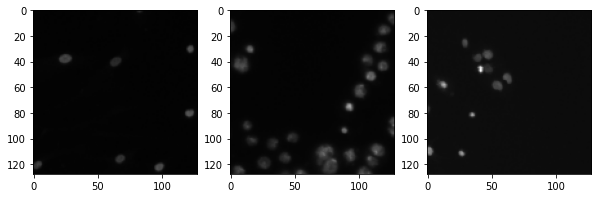

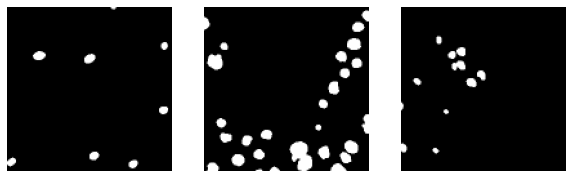

In [10]:
# Plot the image
plt.figure(figsize=(10,4))
for i in range(1,4):
  plt.subplot(1,3,i)
  img_plot = train_input[i]
  plt.imshow(img_plot)
plt.show()

plt.figure(figsize=(10,4))
for i in range(1,4):
  plt.subplot(1,3,i)
  mask_plot = train_mask[i]
  plt.imshow(mask_plot, cmap='gray')
  plt.axis('off')
plt.show()

In [11]:
# Data preprocessing
# Expand the mask dimension
train_mask_np_exp = np.expand_dims(train_mask_np, axis=-1)
test_mask_np_exp = np.expand_dims(test_mask_np, axis=-1)
#Check the mask output
print(train_mask[0].min(), train_mask[0].max())

0 255


In [12]:
# Change the mask value
# Normalize the value then encode it into numerical encoding
converted_masks_train = np.ceil(train_mask_np_exp/255)
converted_masks_test = np.ceil(test_mask_np_exp/255)
converted_masks_train = 1 - converted_masks_train
converted_masks_test = 1 - converted_masks_test

In [13]:
# Normalize the input
converted_inputs_train = train_input_np / 255.0
converted_inputs_test = test_input_np / 255.0

In [14]:
print('converted_mask_train shape', converted_masks_train.shape)
print('converted_input_train shape', converted_inputs_train.shape)
print('converted_mask_test shape', converted_masks_test.shape)
print('converted_input_test shape', converted_inputs_test.shape)

converted_mask_train shape (603, 128, 128, 1)
converted_input_train shape (603, 128, 128, 3)
converted_mask_test shape (67, 128, 128, 1)
converted_input_test shape (67, 128, 128, 3)


In [15]:
#2.4 Do train-test split of train dataset
from sklearn.model_selection import train_test_split
SEED = 12345
X_train, X_val, y_train, y_val = train_test_split(
                                                    converted_inputs_train, 
                                                    converted_masks_train, 
                                                    test_size = 0.2, 
                                                    random_state = SEED
                                                    )

In [16]:
print('Total X_train: ', len(X_train))
print('Total X_val: ', len(X_val))
print('Total y_train: ', len(y_train))
print('Total y_val: ', len(y_val))

Total X_train:  482
Total X_val:  121
Total y_train:  482
Total y_val:  121


In [17]:
#2.5 Convert the numpy array data into tensor slice
train_X = tf.data.Dataset.from_tensor_slices(X_train)
val_X = tf.data.Dataset.from_tensor_slices(X_val)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
val_y = tf.data.Dataset.from_tensor_slices(y_val)
test_x = tf.data.Dataset.from_tensor_slices(converted_inputs_test)
test_y = tf.data.Dataset.from_tensor_slices(converted_masks_test)

In [18]:
#2.6 Zip tensor slice into dataset
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))
test = tf.data.Dataset.zip((test_x, test_y))

In [19]:
#2.7 Convert into prefetch dataset
BATCH_SIZE = 10
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 600//BATCH_SIZE
VALIDATION_STEPS = 200//BATCH_SIZE

train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() 
train = train.prefetch(buffer_size = AUTOTUNE)
val = val.batch(BATCH_SIZE).repeat()
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [20]:
#3. Prepare model
# we are going to create a modifies version of U-NET
# Unet pre-trained model (weights: imagenet) 

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False, 
                                                            weights = "imagenet", 
                                                            input_shape = [128, 128, 3])
# Set the layers
skip_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
    ]

#skip_names = ['conv1/relu', # 64x64
#              'pool2_relu', # 32x32
#              'pool3_relu', # 16x16
#              'pool4_relu', # 8x8
#              'relu'        # 4x4
#              ]

# Output layers
skip_outputs = [base_model.get_layer(name).output for name in skip_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, 
                            outputs=skip_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# Callback the function to build the model
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)

In [21]:
# compile  the model and display the model structure
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

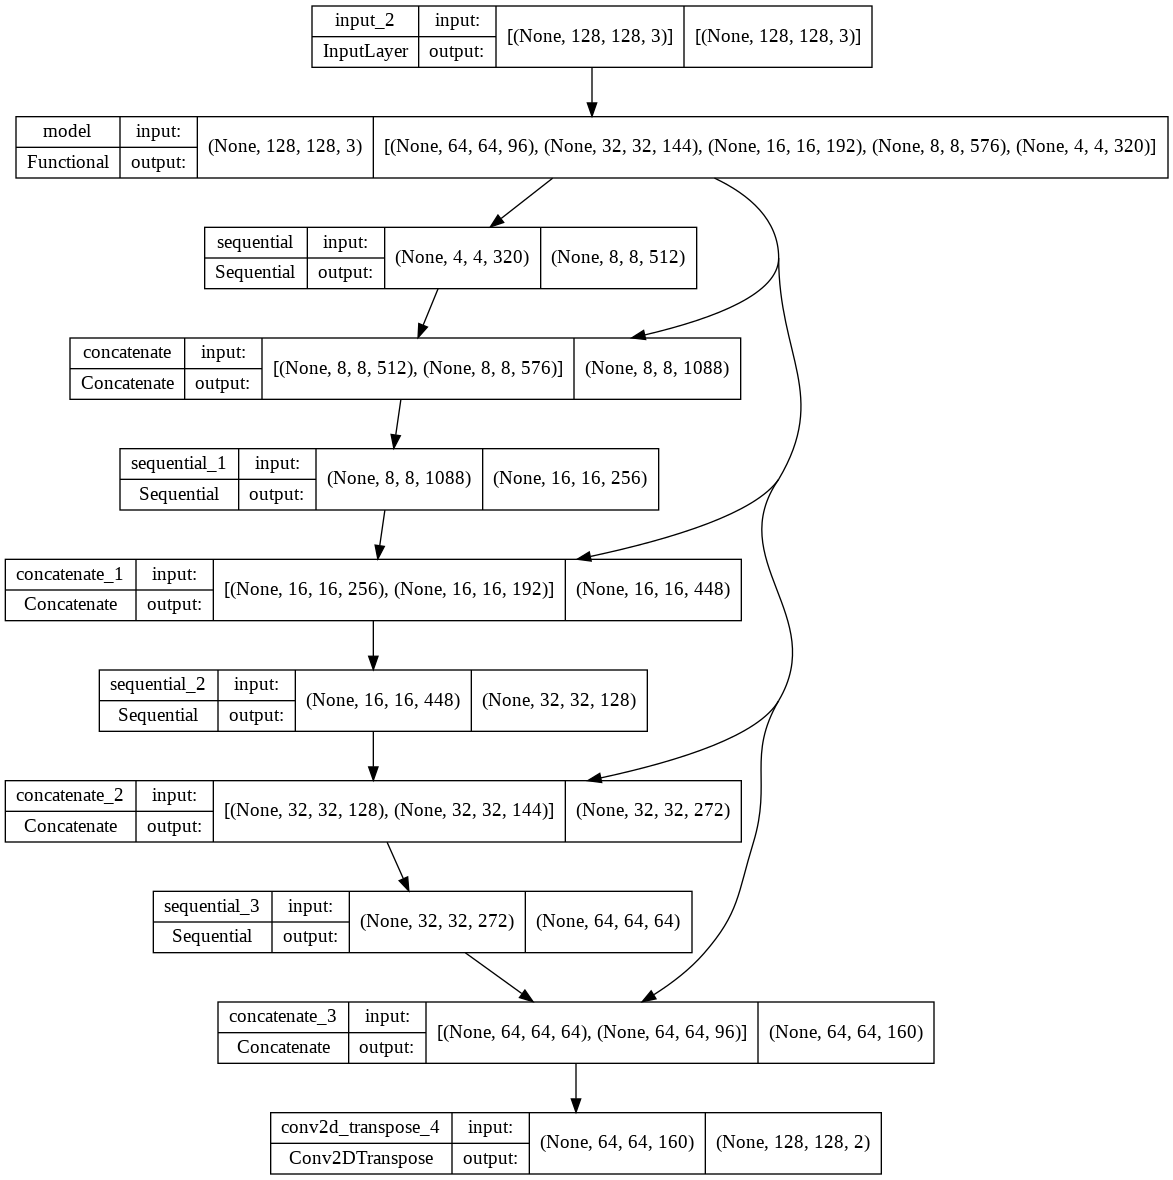

In [22]:
# Show the model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

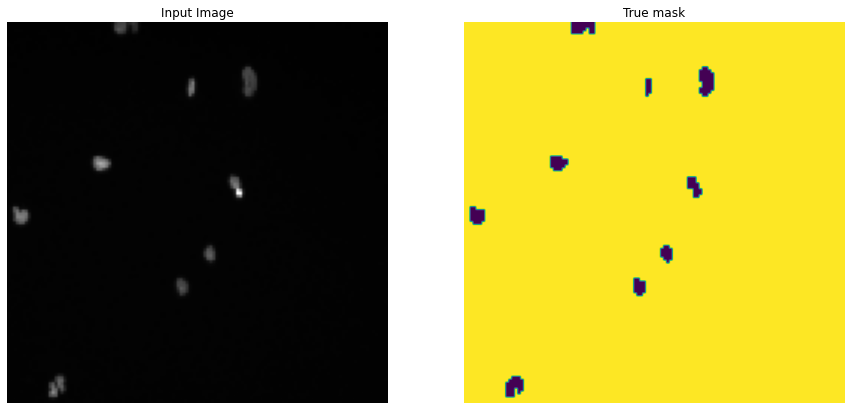

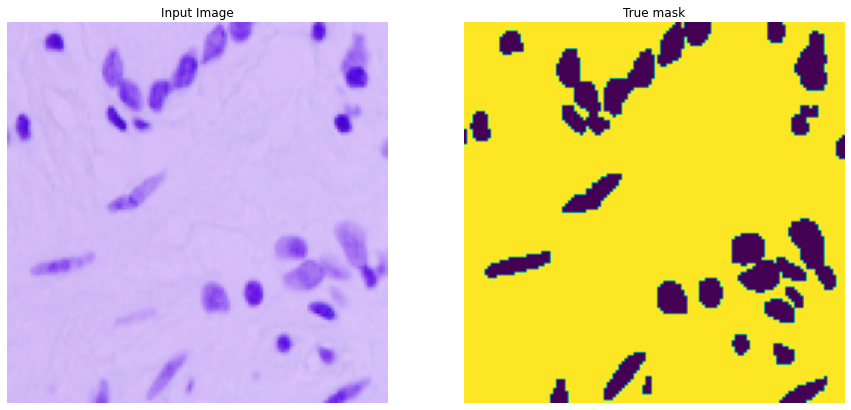

In [23]:
# Create a function to display some examples
def display(display_list):
  plt.figure(figsize=(15,15))
  title = ['Input Image', 'True mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  
  plt.show()

for inputs, masks in train.take(2):
  sample_input, sample_mask = inputs[0], masks[0]
  display([sample_input, sample_mask])

In [27]:
# Create a function to predict
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis =-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

def show_predictions(dataset= None, num=1):
  if dataset:
    for input, mask in dataset.take(num):
      pred_mask = model.predict(input)
      display([input[0], mask[0], create_mask(pred_mask)[0]])
  else:
    display([sample_input, sample_mask, create_mask(model.predict(sample_input[tf.newaxis,...]))[0]])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [31]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from gc import callbacks
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# early stopping is added to avoid overfitting
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience=2, verbose=2)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


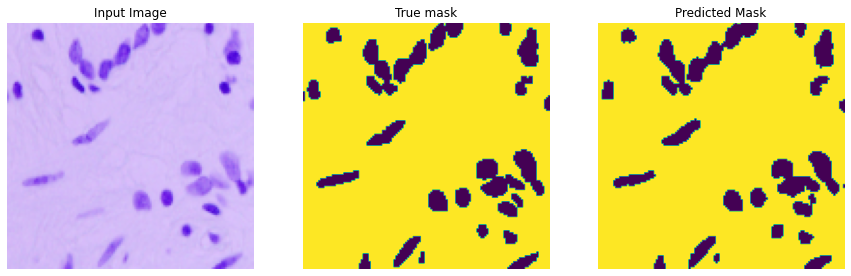


Sample Prediction after epoch 31

60/60 [==============================] - 7s 122ms/step - loss: 0.0506 - accuracy: 0.9792 - val_loss: 0.0936 - val_accuracy: 0.9674
Epoch 31: early stopping


In [29]:
# Start to do the TRAINING
EPOCH = 100

history = model.fit(train, epochs=EPOCH,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    batch_size = BATCH_SIZE,
                    validation_steps=VALIDATION_STEPS,
                    validation_data = val,
                    callbacks=[DisplayCallback(), tensorboard_callback, early_stopping_callback]
                    )

In [ ]:
#tf.keras.backend.clear_session()

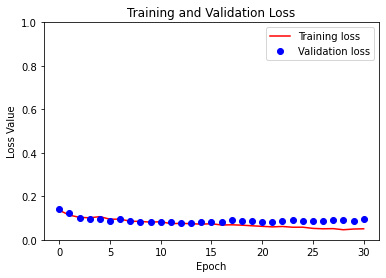

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

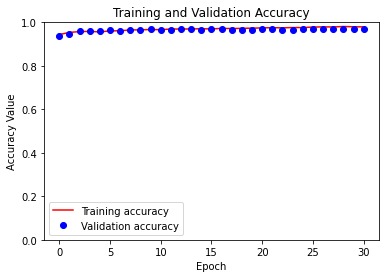

In [33]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(history.epoch, accuracy, 'r', label='Training accuracy')
plt.plot(history.epoch, val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

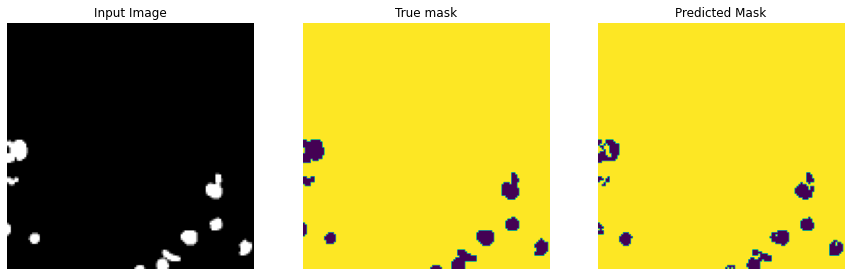

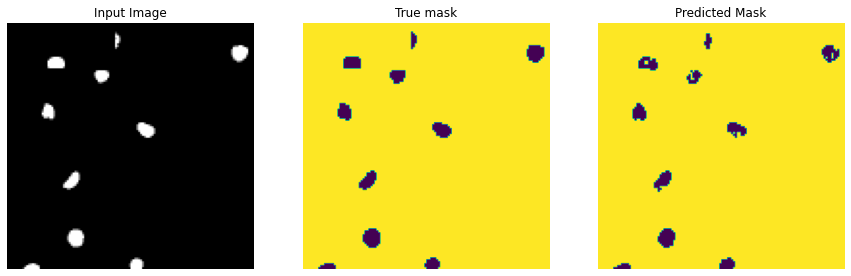

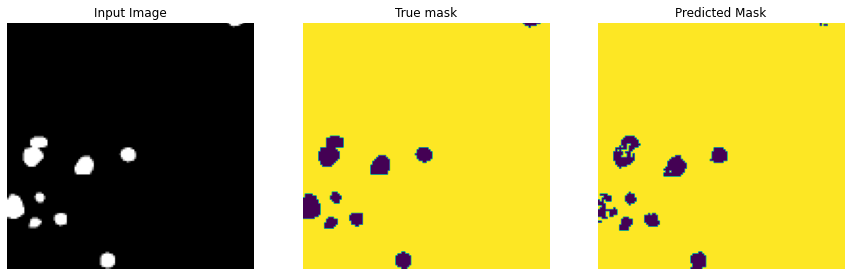

In [34]:
# Make some predictions by calling out the show_predictions funtion
show_predictions(test,3)

In [35]:
#save the model
model.save("/content/drive/MyDrive/image_segementation_nuclei_detection_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/image_segementation_nuclei_detection_model/assets
